In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsbombpy import sb
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix

pd.set_option('display.max_columns', 100)

In [2]:
sb.competitions().query("competition_name == 'La Liga'").sort_values("season_name", ascending=False).head(3)

/Users/artigashugo/miniconda3/lib/python3.8/site-packages/statsbombpy/api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
20,11,90,Spain,La Liga,male,False,False,2020/2021,2022-02-11T14:56:09.076,2022-08-16T21:50:36.812060,2022-08-16T21:50:36.812060,2022-02-11T14:56:09.076
21,11,42,Spain,La Liga,male,False,False,2019/2020,2022-07-15T23:27:24.260122,2021-06-13T16:17:31.694,None,2022-07-15T23:27:24.260122
22,11,4,Spain,La Liga,male,False,False,2018/2019,2022-08-30T23:25:57.118855,2021-07-09T14:53:22.103024,None,2022-08-30T23:25:57.118855


In [3]:
LALIGA_ID = 11
SEASON_2021_ID = 90 

In [4]:
all_matches = sb.matches(competition_id=LALIGA_ID, season_id=SEASON_2021_ID)
match_passes = pd.concat(
               [sb.events(match_id=match_id, split=True, flatten_attrs=False)["passes"]
               .assign(match_week = match_week) 
               .assign(home_team = home_team)
               .assign(away_team = away_team)
               for match_id, match_week, home_team, away_team 
               in zip(
                    all_matches["match_id"], all_matches["match_week"],
                    all_matches["home_team"], all_matches["away_team"]
                     )
                ]
               )

/Users/artigashugo/miniconda3/lib/python3.8/site-packages/statsbombpy/api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)


In [5]:
match_passes.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,related_events,pass,match_id,possession_team_id,player_id,under_pressure,counterpress,off_camera,match_week,home_team,away_team,out
0,3c824f32-fcd1-4191-b824-26bb32d9bd6c,5,1,00:00:00.992,0,0,Pass,2,Real Betis,From Kick Off,Real Betis,Borja Iglesias Quintas,Center Forward,"[60.0, 40.0]",1.137457,[953b857b-55b9-4f14-974c-63e2929e6de1],"{'recipient': {'id': 2948, 'name': 'Nabil Feki...",3773631,218,11391,NaN,NaN,NaN,22,Real Betis,Barcelona,NaN
1,723a939c-cc2f-49a9-8b95-20373c926cc6,7,1,00:00:02.130,0,2,Pass,2,Real Betis,From Kick Off,Real Betis,Nabil Fekir,Center Attacking Midfield,"[56.7, 41.1]",1.100128,[59962ded-d646-4f9c-bf6d-ebba06ef28d3],"{'recipient': {'id': 42282, 'name': 'Paul Edga...",3773631,218,2948,NaN,NaN,NaN,22,Real Betis,Barcelona,NaN
2,90973a59-4f2e-436c-a982-45a6fd35280d,10,1,00:00:04.345,0,4,Pass,2,Real Betis,From Kick Off,Real Betis,Paul Edgar Akouokou,Right Defensive Midfield,"[43.5, 37.6]",1.746256,[f719fb9a-1271-49c5-9051-3c7e7154e0e9],"{'recipient': {'id': 6752, 'name': 'Víctor Ruí...",3773631,218,42282,NaN,NaN,NaN,22,Real Betis,Barcelona,NaN
3,5d05e5a3-ccce-46b9-8436-b140ee4f51fd,13,1,00:00:07.271,0,7,Pass,2,Real Betis,From Kick Off,Real Betis,Víctor Ruíz Torre,Left Center Back,"[30.2, 25.3]",1.486695,[6040c0e0-1813-4a68-85ec-3f8ecdeee7c6],"{'recipient': {'id': 6648, 'name': 'Aïssa Mand...",3773631,218,6752,NaN,NaN,NaN,22,Real Betis,Barcelona,NaN
4,887eb3ef-9531-433a-95a2-b15295834cd9,17,1,00:00:09.422,0,9,Pass,2,Real Betis,From Kick Off,Real Betis,Aïssa Mandi,Right Center Back,"[27.8, 46.1]",1.672701,"[8e78399b-61d6-40ef-8244-2f4a62e9dc71, 9d10e36...","{'recipient': {'id': 6851, 'name': 'Aitor Ruib...",3773631,218,6648,True,NaN,NaN,22,Real Betis,Barcelona,NaN


In [6]:
print(f"Dataset with {len(match_passes):,} passes")
print(list(match_passes.columns))

Dataset with 40,337 passes
['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'player', 'position', 'location', 'duration', 'related_events', 'pass', 'match_id', 'possession_team_id', 'player_id', 'under_pressure', 'counterpress', 'off_camera', 'match_week', 'home_team', 'away_team', 'out']


In [7]:
def extract_pass_features(df):
    
    df["outcome"] = df["pass"].apply(lambda x : x.get("outcome", {}).get("name"))
    df["recipient_id"] = df["pass"].apply(lambda x : x.get("recipient", {}).get("id"))
    df["length"] = df["pass"].apply(lambda x : x.get("length"))
    df["angle"] = df["pass"].apply(lambda x : x.get("angle"))
    df["height"] = df["pass"].apply(lambda x : x.get("height", {}).get("name"))
    df["body_part"] = df["pass"].apply(lambda x : x.get("body_part", {}).get("name"))
    df["end_location"] = df["pass"].apply(lambda x : x.get("end_location"))
    df["home"] = df["possession_team"] == df["home_team"]
    df["opponent"] = df.apply(lambda x : x["home_team"] if x["home_team"] != x["possession_team"] else x["away_team"], axis=1)
    df["n_related_events"] = df.related_events.apply(lambda x : len(x) if type(x) == list else None).fillna(0)
    # df['horizontal_field_zone'] = df['location'].apply(lambda x: 1 if x[0]<30 else (3 if x[0]>80 else 2))

    return df

def manage_nas(df):
    for column in ["under_pressure", "counterpress", "off_camera"]:
        df[column] = df[column].fillna(False)
    df["outcome"] = df["outcome"].fillna("Completed")
    return df

def zone(x,N,l):
    if x!=l :
        step = l/N
        return int(x//step)
    else: return int(N-1)

def field_partition(df):
    n = 50
    m = 32
    df['field_zone_x'] = df['location'].apply(lambda x: zone(x[0],n,120))
    df['field_zone_y'] = df['location'].apply(lambda x: zone(x[1],m,80))
    df['end_field_zone_x'] = df['end_location'].apply(lambda x: zone(x[0],n,120))
    df['end_field_zone_y'] = df['end_location'].apply(lambda x: zone(x[1],m,80))
    return df

In [8]:
match_passes = extract_pass_features(match_passes)
match_passes = manage_nas(match_passes)
match_passes = field_partition(match_passes)
match_passes = match_passes[(match_passes['outcome'] == 'Completed') | (match_passes['outcome']== 'Incomplete') | (match_passes['outcome']== 'Out') ]

In [9]:
match_passes.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,related_events,pass,match_id,possession_team_id,player_id,under_pressure,counterpress,off_camera,match_week,home_team,away_team,out,outcome,recipient_id,length,angle,height,body_part,end_location,home,opponent,n_related_events,field_zone_x,field_zone_y,end_field_zone_x,end_field_zone_y
0,3c824f32-fcd1-4191-b824-26bb32d9bd6c,5,1,00:00:00.992,0,0,Pass,2,Real Betis,From Kick Off,Real Betis,Borja Iglesias Quintas,Center Forward,"[60.0, 40.0]",1.137457,[953b857b-55b9-4f14-974c-63e2929e6de1],"{'recipient': {'id': 2948, 'name': 'Nabil Feki...",3773631,218,11391,False,False,False,22,Real Betis,Barcelona,NaN,Completed,2948.0,3.114482,3.045119,Ground Pass,Right Foot,"[56.9, 40.3]",True,Barcelona,1.0,25,16,23,16
1,723a939c-cc2f-49a9-8b95-20373c926cc6,7,1,00:00:02.130,0,2,Pass,2,Real Betis,From Kick Off,Real Betis,Nabil Fekir,Center Attacking Midfield,"[56.7, 41.1]",1.100128,[59962ded-d646-4f9c-bf6d-ebba06ef28d3],"{'recipient': {'id': 42282, 'name': 'Paul Edga...",3773631,218,2948,False,False,False,22,Real Betis,Barcelona,NaN,Completed,42282.0,13.971757,-2.880990,Ground Pass,Right Foot,"[43.2, 37.5]",True,Barcelona,1.0,23,16,18,15
2,90973a59-4f2e-436c-a982-45a6fd35280d,10,1,00:00:04.345,0,4,Pass,2,Real Betis,From Kick Off,Real Betis,Paul Edgar Akouokou,Right Defensive Midfield,"[43.5, 37.6]",1.746256,[f719fb9a-1271-49c5-9051-3c7e7154e0e9],"{'recipient': {'id': 6752, 'name': 'Víctor Ruí...",3773631,218,42282,False,False,False,22,Real Betis,Barcelona,NaN,Completed,6752.0,17.582378,-2.428648,Ground Pass,Right Foot,"[30.2, 26.1]",True,Barcelona,1.0,18,15,12,10
3,5d05e5a3-ccce-46b9-8436-b140ee4f51fd,13,1,00:00:07.271,0,7,Pass,2,Real Betis,From Kick Off,Real Betis,Víctor Ruíz Torre,Left Center Back,"[30.2, 25.3]",1.486695,[6040c0e0-1813-4a68-85ec-3f8ecdeee7c6],"{'recipient': {'id': 6648, 'name': 'Aïssa Mand...",3773631,218,6752,False,False,False,22,Real Betis,Barcelona,NaN,Completed,6648.0,18.660385,1.651267,Ground Pass,Left Foot,"[28.7, 43.9]",True,Barcelona,1.0,12,10,11,17
4,887eb3ef-9531-433a-95a2-b15295834cd9,17,1,00:00:09.422,0,9,Pass,2,Real Betis,From Kick Off,Real Betis,Aïssa Mandi,Right Center Back,"[27.8, 46.1]",1.672701,"[8e78399b-61d6-40ef-8244-2f4a62e9dc71, 9d10e36...","{'recipient': {'id': 6851, 'name': 'Aitor Ruib...",3773631,218,6648,True,False,False,22,Real Betis,Barcelona,NaN,Completed,6851.0,30.927334,0.601455,Ground Pass,Right Foot,"[53.3, 63.6]",True,Barcelona,2.0,11,18,22,25


# Number of passes attempted by Barcelona vs opponents

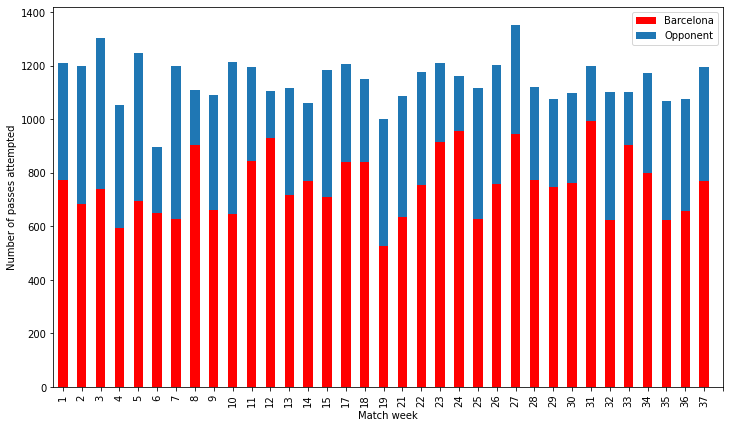

In [10]:
match_passes.query("possession_team == 'Barcelona'").match_week.value_counts().sort_index().plot.bar(figsize=(12,7), color = "red", label="Barcelona")
match_passes.query("possession_team != 'Barcelona'").match_week.value_counts().sort_index().plot.bar(figsize=(12,7), bottom = match_passes.query("possession_team == 'Barcelona'").match_week.value_counts().sort_index(), label="Opponent")
plt.xlabel("Match week")
plt.ylabel("Number of passes attempted")
plt.xticks(range(0,36))
plt.legend();

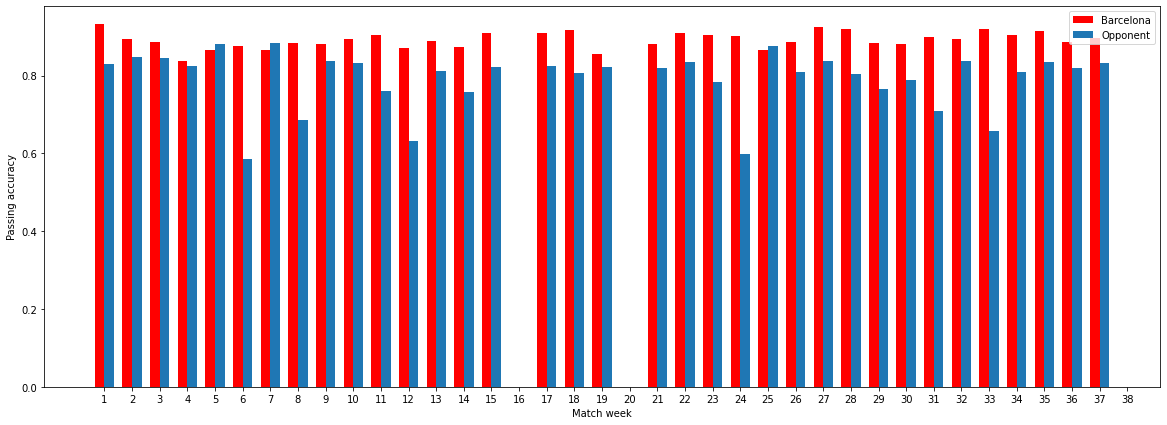

In [11]:
plt.figure(figsize=(20,7))
barcelona = match_passes.query("possession_team == 'Barcelona'").groupby("match_week").outcome.value_counts(normalize=True).loc[:,"Completed", :]
plt.bar(barcelona.index, barcelona.values, width=0.35, color="red", label ="Barcelona")

opponents = match_passes.query("possession_team != 'Barcelona'").groupby("match_week").outcome.value_counts(normalize=True).loc[:,"Completed", :]
opponents.index = (opponents.index + 0.35).astype(float)
plt.bar(opponents.index, opponents.values, width=0.35, label="Opponent")
plt.xticks([x+0.35/2 for x in range(1, 39)], range(1, 39));
plt.xlabel("Match week")
plt.ylabel("Passing accuracy")
plt.legend(loc="upper right");

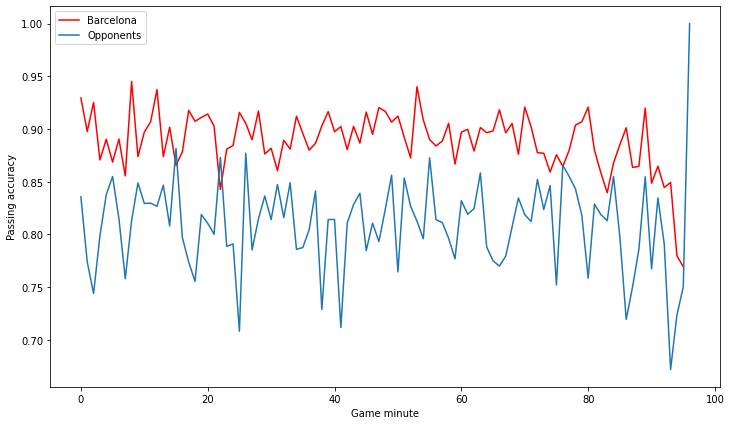

In [12]:
plt.figure(figsize=(12,7))
match_passes.query("possession_team == 'Barcelona'").groupby("minute")["outcome"].value_counts(normalize=True).loc[:,"Completed"].plot(color="red", label="Barcelona")
match_passes.query("possession_team != 'Barcelona'").groupby("minute")["outcome"].value_counts(normalize=True).loc[:,"Completed"].plot(label="Opponents")
plt.xlabel("Game minute")
plt.ylabel("Passing accuracy")
plt.legend();

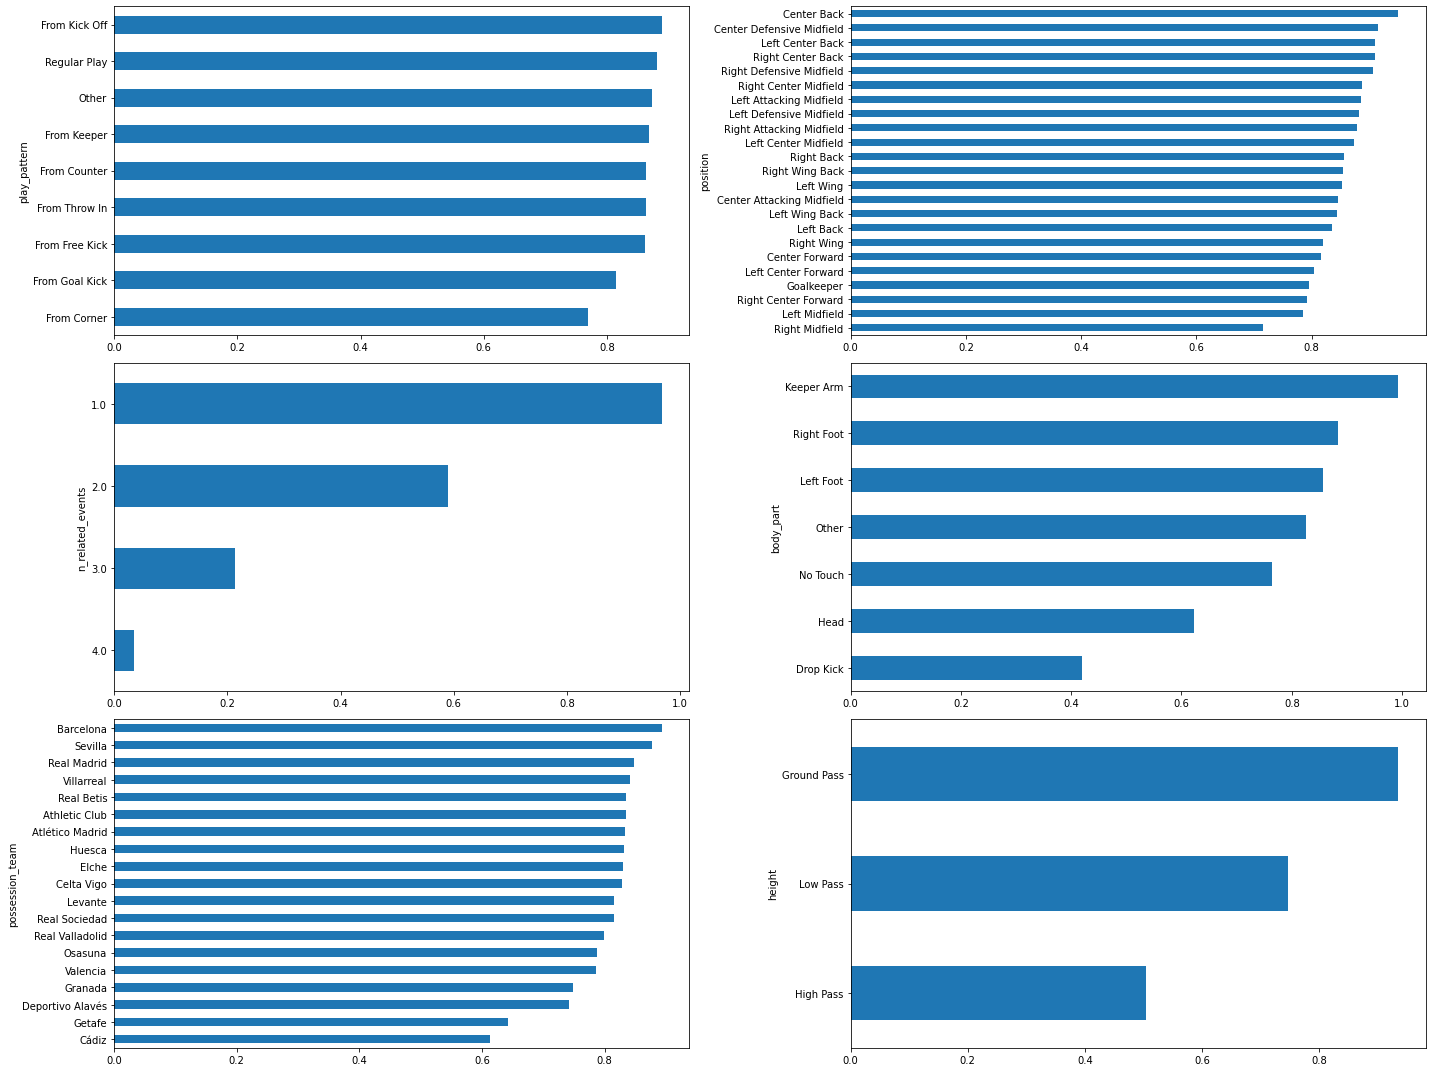

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
for i, column in enumerate(["play_pattern", "position", "n_related_events", "body_part", "possession_team", "height"], 1):
    ax = plt.subplot(3, 2, i)
    match_passes.groupby(column)["outcome"].value_counts(normalize=True).loc[:,"Completed"].sort_values().plot.barh(ax=ax)

fig.tight_layout()

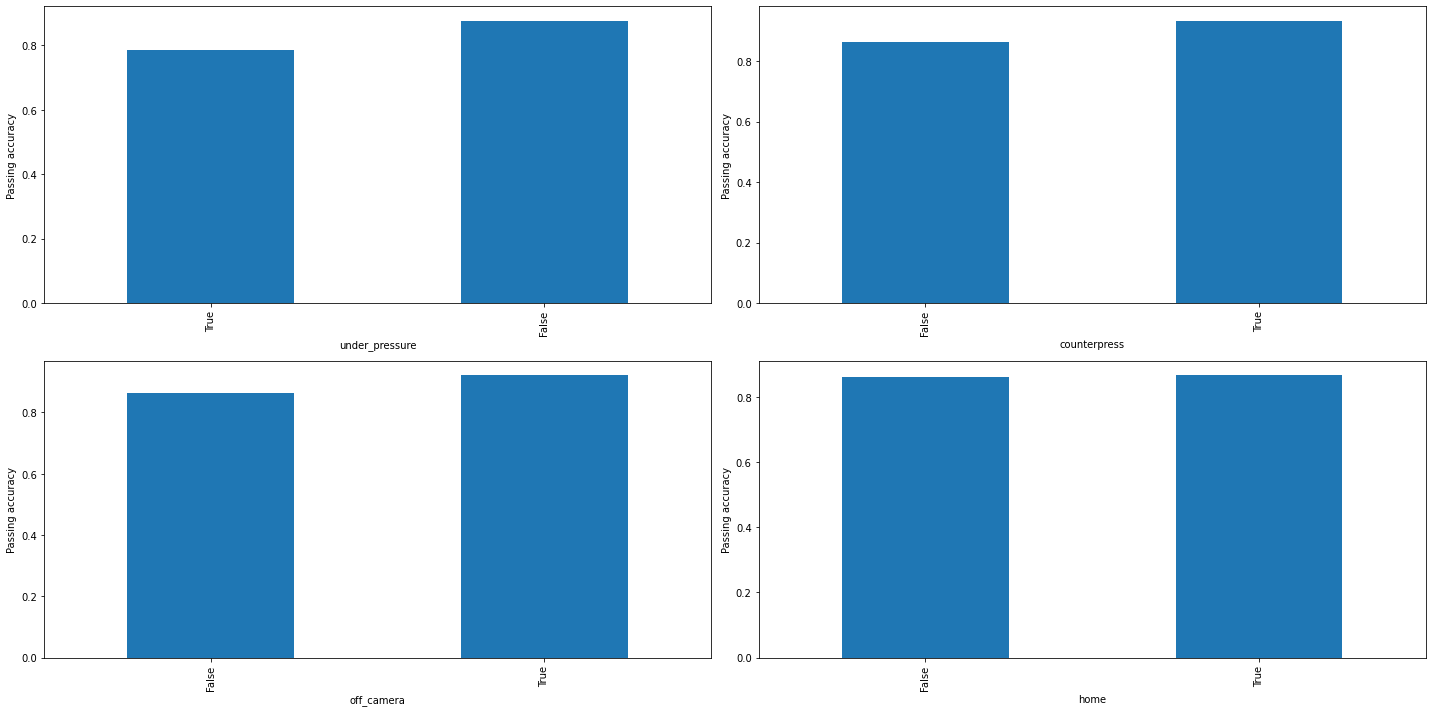

In [14]:
fig, axes = plt.subplots(2,2, figsize=(20, 10))

for i, column in enumerate(["under_pressure", "counterpress", "off_camera", "home"], 1):
    ax = plt.subplot(2, 2, i)
    match_passes.groupby(column)["outcome"].value_counts(normalize=True).loc[:,"Completed"].sort_values().plot.bar(ax=ax)
    ax.set_ylabel("Passing accuracy")

fig.tight_layout()

No handles with labels found to put in legend.


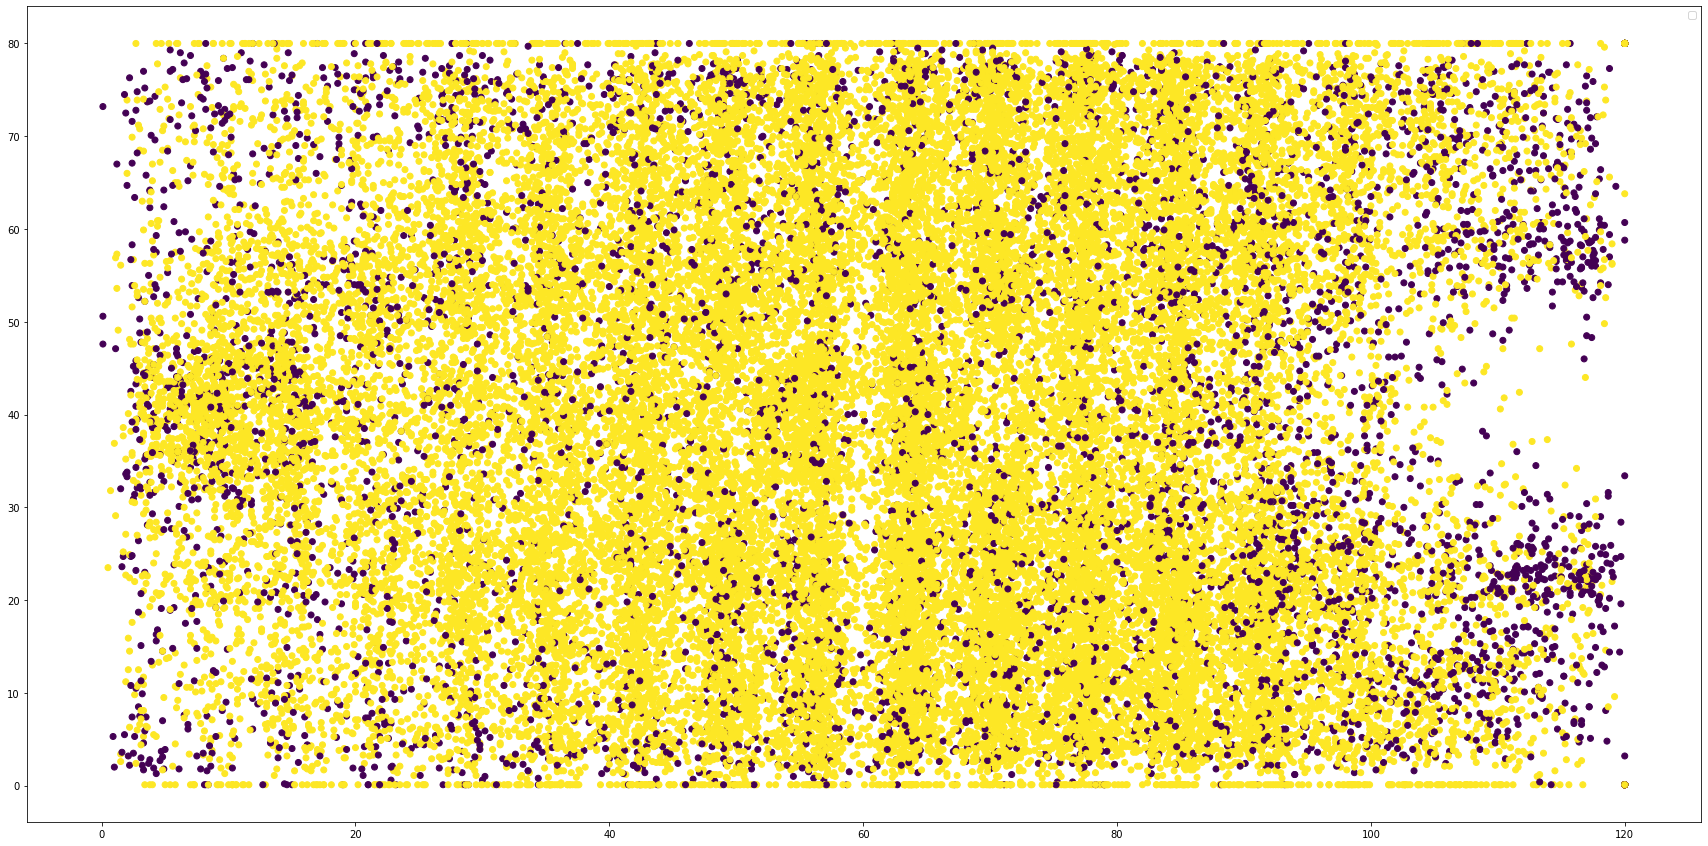

In [15]:
plt.figure(figsize=(30,15))
locations = match_passes["location"].apply(pd.Series)
locations.columns = ["x", "y"]
plt.scatter(locations["x"], locations["y"], c = match_passes["outcome"] == "Completed")
plt.legend();

## Modeling

In [42]:
match_passes['pass'].iloc[0]

{'recipient': {'id': 2948, 'name': 'Nabil Fekir'},
 'length': 3.1144824,
 'angle': 3.0451188,
 'height': {'id': 1, 'name': 'Ground Pass'},
 'end_location': [56.9, 40.3],
 'type': {'id': 65, 'name': 'Kick Off'},
 'body_part': {'id': 40, 'name': 'Right Foot'}}

In [60]:
TARGET = "outcome"
FEATURES = ["minute", "play_pattern", "location", "counterpress", "under_pressure", "match_week", "length", "angle", "height", "body_part","end_location"]

In [61]:
X = match_passes[FEATURES].reset_index(drop=True)
y = (match_passes[TARGET] == "Completed").astype(int).reset_index(drop=True)

In [62]:
X["location_x"], X["location_y"] = X["location"].apply(pd.Series).T.values
X["end_location_x"], X["end_location_y"] = X["end_location"].apply(pd.Series).T.values
X = X.drop(["location", "end_location"], axis=1)

X["counterpress"] = X["counterpress"].astype(int)
X["under_pressure"] = X["under_pressure"].astype(int)

In [63]:
CATEGORICAL_COLUMNS = ["play_pattern", "height", "body_part"]
encoder = OneHotEncoder()
encoded_cat = pd.DataFrame(encoder.fit_transform(X[CATEGORICAL_COLUMNS]).toarray(), columns = encoder.get_feature_names(input_features=CATEGORICAL_COLUMNS)).astype(int)

X = pd.concat([X, encoded_cat], axis=1).drop(CATEGORICAL_COLUMNS, axis=1)

/Users/artigashugo/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001,shuffle=False)

In [71]:
model = XGBClassifier(n_estimators = 700, early_stopping_rounds=50, learning_rate=0.05, max_depth = 4, eval_metric="auc",scale_pos_weight = (len(y_train)-sum(y_train))/sum(y_train))
model.fit(X_train, y_train,
         eval_set = [(X_train, y_train), (X_test, y_test)],
         verbose=50
         )

[14:33:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.84464	validation_1-auc:0.76471
[50]	validation_0-auc:0.90316	validation_1-auc:0.85294
[100]	validation_0-auc:0.91587	validation_1-auc:0.88655
[150]	validation_0-auc:0.92189	validation_1-auc:0.87395
[200]	validation_0-auc:0.92588	validation_1-auc:0.87815
[250]	validation_0-auc:0.92861	validation_1-auc:0.88655
[300]	validation_0-auc:0.93100	validation_1-auc:0.89076
[350]	validation_0-auc:0.93324	validation_1-auc:0.89916
[400]	validation_0-auc:0.93507	validation_1-auc:0.90756
[450]	validation_0-auc:0.93681	validation_1-auc:0.90756
[500]	validation_0-auc:0.93872	validation_1-auc:0.91597
[550]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=700, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.15588430755005922, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
print("AUC score:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 3))
confusion_matrix(y_test, model.predict(X_test))

AUC score: 0.908


array([[ 5,  2],
       [ 4, 30]])

In [73]:
pd.DataFrame(model.feature_importances_, index=X_train.columns , columns =["importance"]).sort_values("importance", ascending= False).T

,height_Ground Pass,height_High Pass,under_pressure,length,end_location_x,angle,body_part_None,end_location_y,body_part_Keeper Arm,play_pattern_From Throw In,body_part_Right Foot,body_part_Head,location_y,play_pattern_From Corner,play_pattern_Regular Play,location_x,play_pattern_From Free Kick,play_pattern_From Goal Kick,counterpress,height_Low Pass,play_pattern_From Kick Off,minute,body_part_Left Foot,play_pattern_From Counter,match_week,body_part_Other,body_part_No Touch,body_part_Drop Kick,play_pattern_From Keeper,play_pattern_Other
importance,0.577979,0.061947,0.044254,0.038922,0.035956,0.029639,0.023564,0.0216,0.015645,0.012959,0.012714,0.01225,0.011648,0.011134,0.010941,0.009826,0.008514,0.00826,0.007878,0.007743,0.006099,0.004921,0.0049,0.004773,0.004431,0.00426,0.003656,0.001895,0.001691,0.0


In [85]:
match_passes = match_passes.copy()
match_passes['prob'] = model.predict_proba(X).copy()
match_passes['target'] = y
match_passes['risk'] = 1-y.values - match_passes['prob']

In [86]:
prob_per_zone_to_zone = match_passes.groupby(['field_zone_x','field_zone_y','end_field_zone_x','end_field_zone_y']).mean()['prob']
prob_per_zone_to_zone

field_zone_x  field_zone_y  end_field_zone_x  end_field_zone_y
0             0             1                 0                   0.998501
                                              1                   0.995006
              1             1                 6                   0.114583
                            2                 1                   0.987532
                            8                 1                   0.943333
                                                                    ...   
49            31            48                29                  0.081573
                                              30                  0.107554
                            49                16                  0.965552
                                              17                  0.998606
                                              26                  0.258706
Name: prob, Length: 36851, dtype: float32

In [87]:
interception_prob = 1-prob_per_zone_to_zone
interception_prob

field_zone_x  field_zone_y  end_field_zone_x  end_field_zone_y
0             0             1                 0                   0.001499
                                              1                   0.004994
              1             1                 6                   0.885417
                            2                 1                   0.012468
                            8                 1                   0.056667
                                                                    ...   
49            31            48                29                  0.918427
                                              30                  0.892446
                            49                16                  0.034448
                                              17                  0.001394
                                              26                  0.741294
Name: prob, Length: 36851, dtype: float32

In [88]:
def risk(df):
    l = []
    for i in df.index:
        x = df.iloc[[i]]
        risk = interception_prob.loc[(x['field_zone_x'].values[0],x['field_zone_y'].values[0],x['end_field_zone_x'].values[0],x['end_field_zone_y'].values[0])]
        l.append(risk)
    df['risk'] = np.array(l)
    return df
match_passes = risk(match_passes)

### Valuing pass

In [89]:
df_epv= pd.read_csv('EPV_data.csv',';',header= None)
df_epv

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.0046,0.0046,0.0045,0.0046,0.0048,0.0051,0.0054,0.0057,0.0059,0.0062,0.0066,0.0068,0.0071,0.0072,0.0073,0.0077,0.0082,0.0086,0.0088,0.0092,0.0096,0.0100,0.0104,0.0110,0.0117,0.0123,0.0127,0.0131,0.0135,0.0142,0.0150,0.0160,0.0170,0.0181,0.0192,0.0208,0.0227,0.0244,0.0259,0.0276,0.0297,0.0313,0.0326,0.0341,0.0356,0.0365,0.0368,0.0388,0.0424,0.0443
1,0.0044,0.0044,0.0045,0.0046,0.0049,0.0052,0.0055,0.0058,0.0060,0.0062,0.0066,0.0069,0.0072,0.0074,0.0075,0.0079,0.0084,0.0087,0.0090,0.0093,0.0097,0.0102,0.0106,0.0112,0.0118,0.0123,0.0128,0.0132,0.0136,0.0143,0.0152,0.0162,0.0171,0.0183,0.0196,0.0211,0.0229,0.0246,0.0261,0.0278,0.0298,0.0314,0.0327,0.0342,0.0359,0.0368,0.0370,0.0388,0.0421,0.0437
2,0.0041,0.0042,0.0044,0.0047,0.0052,0.0056,0.0058,0.0060,0.0061,0.0063,0.0067,0.0070,0.0074,0.0076,0.0079,0.0083,0.0087,0.0090,0.0092,0.0095,0.0101,0.0106,0.0111,0.0115,0.0119,0.0124,0.0130,0.0135,0.0139,0.0146,0.0156,0.0165,0.0174,0.0186,0.0202,0.0218,0.0232,0.0248,0.0265,0.0283,0.0300,0.0315,0.0328,0.0345,0.0366,0.0376,0.0376,0.0388,0.0413,0.0425
3,0.0041,0.0042,0.0045,0.0049,0.0054,0.0058,0.0061,0.0062,0.0062,0.0064,0.0068,0.0072,0.0075,0.0079,0.0082,0.0085,0.0089,0.0092,0.0094,0.0098,0.0104,0.0109,0.0114,0.0118,0.0122,0.0126,0.0133,0.0138,0.0142,0.0150,0.0160,0.0170,0.0179,0.0192,0.0209,0.0224,0.0237,0.0252,0.0268,0.0284,0.0300,0.0316,0.0332,0.0351,0.0373,0.0386,0.0392,0.0400,0.0411,0.0417
4,0.0044,0.0045,0.0048,0.0052,0.0056,0.0060,0.0062,0.0064,0.0065,0.0067,0.0070,0.0073,0.0077,0.0080,0.0083,0.0087,0.0092,0.0095,0.0097,0.0101,0.0107,0.0113,0.0117,0.0121,0.0125,0.0129,0.0136,0.0141,0.0146,0.0153,0.0164,0.0175,0.0186,0.0200,0.0215,0.0230,0.0243,0.0256,0.0269,0.0282,0.0296,0.0315,0.0339,0.0361,0.0380,0.0400,0.0418,0.0424,0.0416,0.0412
5,0.0045,0.0047,0.0051,0.0054,0.0057,0.0060,0.0063,0.0066,0.0067,0.0069,0.0072,0.0075,0.0079,0.0082,0.0085,0.0089,0.0094,0.0098,0.0100,0.0104,0.0111,0.0116,0.0120,0.0124,0.0127,0.0131,0.0138,0.0144,0.0149,0.0157,0.0169,0.0180,0.0191,0.0204,0.0219,0.0234,0.0248,0.0261,0.0274,0.0287,0.0300,0.0323,0.0357,0.0382,0.0399,0.0421,0.0447,0.0452,0.0438,0.0430
6,0.0047,0.0049,0.0053,0.0056,0.0057,0.0060,0.0064,0.0067,0.0068,0.0070,0.0075,0.0078,0.0080,0.0083,0.0087,0.0091,0.0096,0.0100,0.0103,0.0108,0.0115,0.0119,0.0123,0.0125,0.0127,0.0132,0.0140,0.0147,0.0153,0.0162,0.0174,0.0184,0.0192,0.0204,0.0221,0.0237,0.0251,0.0267,0.0285,0.0299,0.0311,0.0340,0.0387,0.0416,0.0429,0.0449,0.0476,0.0486,0.0477,0.0473
7,0.0047,0.0050,0.0054,0.0057,0.0059,0.0062,0.0067,0.0070,0.0070,0.0072,0.0077,0.0080,0.0082,0.0085,0.0090,0.0094,0.0098,0.0102,0.0106,0.0111,0.0117,0.0122,0.0125,0.0128,0.0131,0.0136,0.0143,0.0151,0.0157,0.0166,0.0177,0.0187,0.0195,0.0207,0.0223,0.0238,0.0253,0.0273,0.0299,0.0321,0.0341,0.0373,0.0417,0.0446,0.0460,0.0489,0.0534,0.0546,0.0525,0.0514
8,0.0048,0.0050,0.0055,0.0059,0.0062,0.0066,0.0071,0.0074,0.0074,0.0076,0.0079,0.0082,0.0085,0.0088,0.0092,0.0095,0.0100,0.0104,0.0107,0.0112,0.0119,0.0124,0.0128,0.0132,0.0136,0.0142,0.0148,0.0155,0.0163,0.0171,0.0179,0.0188,0.0199,0.0211,0.0225,0.0238,0.0252,0.0278,0.0316,0.0353,0.0390,0.0421,0.0447,0.0471,0.0492,0.0541,0.0619,0.0633,0.0582,0.0556
9,0.0050,0.0052,0.0058,0.0062,0.0065,0.0069,0.0074,0.0077,0.0077,0.0078,0.0081,0.0084,0.0088,0.0091,0.0094,0.0097,0.0102,0.0106,0.0109,0.0114,0.0120,0.0125,0.0131,0.0136,0.0141,0.0146,0.0152,0.0158,0.0166,0.0173,0.0180,0.0189,0.0201,0.0214,0.0227,0.0243,0.0263,0.0293,0.0333,0.0373,0.0413,0.0452,0.0490,0.0540,0.0600,0.0655,0.0703,0.0702,0.0651,0.0626


In [90]:
def incremental_expected_possesion_value(df):
    l = []
    for i in df.index:
        x = df.iloc[[i]]
        epv = df_epv.loc[x['end_field_zone_y'].values[0],x['end_field_zone_x'].values[0]]-df_epv.loc[x['field_zone_y'].values[0],x['field_zone_x'].values[0]]
        l.append(epv)
    df['delta_EPV'] = np.array(l)
    return df
match_passes = incremental_expected_possesion_value(match_passes)

In [91]:
match_passes.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,related_events,pass,match_id,possession_team_id,player_id,under_pressure,counterpress,off_camera,match_week,home_team,away_team,out,outcome,recipient_id,length,angle,height,body_part,end_location,home,opponent,n_related_events,field_zone_x,field_zone_y,end_field_zone_x,end_field_zone_y,prob,risk,delta_EPV,target
0,3c824f32-fcd1-4191-b824-26bb32d9bd6c,5,1,00:00:00.992,0,0,Pass,2,Real Betis,From Kick Off,Real Betis,Borja Iglesias Quintas,Center Forward,"[60.0, 40.0]",1.137457,[953b857b-55b9-4f14-974c-63e2929e6de1],"{'recipient': {'id': 2948, 'name': 'Nabil Feki...",3773631,218,11391,False,False,False,22,Real Betis,Barcelona,NaN,Completed,2948.0,3.114482,3.045119,Ground Pass,Right Foot,"[56.9, 40.3]",True,Barcelona,1.0,25,16,23,16,0.484972,0.770992,-0.0002,1
1,723a939c-cc2f-49a9-8b95-20373c926cc6,7,1,00:00:02.130,0,2,Pass,2,Real Betis,From Kick Off,Real Betis,Nabil Fekir,Center Attacking Midfield,"[56.7, 41.1]",1.100128,[59962ded-d646-4f9c-bf6d-ebba06ef28d3],"{'recipient': {'id': 42282, 'name': 'Paul Edga...",3773631,218,2948,False,False,False,22,Real Betis,Barcelona,NaN,Completed,42282.0,13.971757,-2.880990,Ground Pass,Right Foot,"[43.2, 37.5]",True,Barcelona,1.0,23,16,18,15,0.023153,0.968601,-0.0023,1
2,90973a59-4f2e-436c-a982-45a6fd35280d,10,1,00:00:04.345,0,4,Pass,2,Real Betis,From Kick Off,Real Betis,Paul Edgar Akouokou,Right Defensive Midfield,"[43.5, 37.6]",1.746256,[f719fb9a-1271-49c5-9051-3c7e7154e0e9],"{'recipient': {'id': 6752, 'name': 'Víctor Ruí...",3773631,218,42282,False,False,False,22,Real Betis,Barcelona,NaN,Completed,6752.0,17.582378,-2.428648,Ground Pass,Right Foot,"[30.2, 26.1]",True,Barcelona,1.0,18,15,12,10,0.030088,0.969912,-0.0025,1
3,5d05e5a3-ccce-46b9-8436-b140ee4f51fd,13,1,00:00:07.271,0,7,Pass,2,Real Betis,From Kick Off,Real Betis,Víctor Ruíz Torre,Left Center Back,"[30.2, 25.3]",1.486695,[6040c0e0-1813-4a68-85ec-3f8ecdeee7c6],"{'recipient': {'id': 6648, 'name': 'Aïssa Mand...",3773631,218,6752,False,False,False,22,Real Betis,Barcelona,NaN,Completed,6648.0,18.660385,1.651267,Ground Pass,Left Foot,"[28.7, 43.9]",True,Barcelona,1.0,12,10,11,17,0.054022,0.945978,-0.0001,1
4,887eb3ef-9531-433a-95a2-b15295834cd9,17,1,00:00:09.422,0,9,Pass,2,Real Betis,From Kick Off,Real Betis,Aïssa Mandi,Right Center Back,"[27.8, 46.1]",1.672701,"[8e78399b-61d6-40ef-8244-2f4a62e9dc71, 9d10e36...","{'recipient': {'id': 6851, 'name': 'Aitor Ruib...",3773631,218,6648,True,False,False,22,Real Betis,Barcelona,NaN,Completed,6851.0,30.927334,0.601455,Ground Pass,Right Foot,"[53.3, 63.6]",True,Barcelona,2.0,11,18,22,25,0.491934,0.508066,0.0034,1


### Quantifying decision making

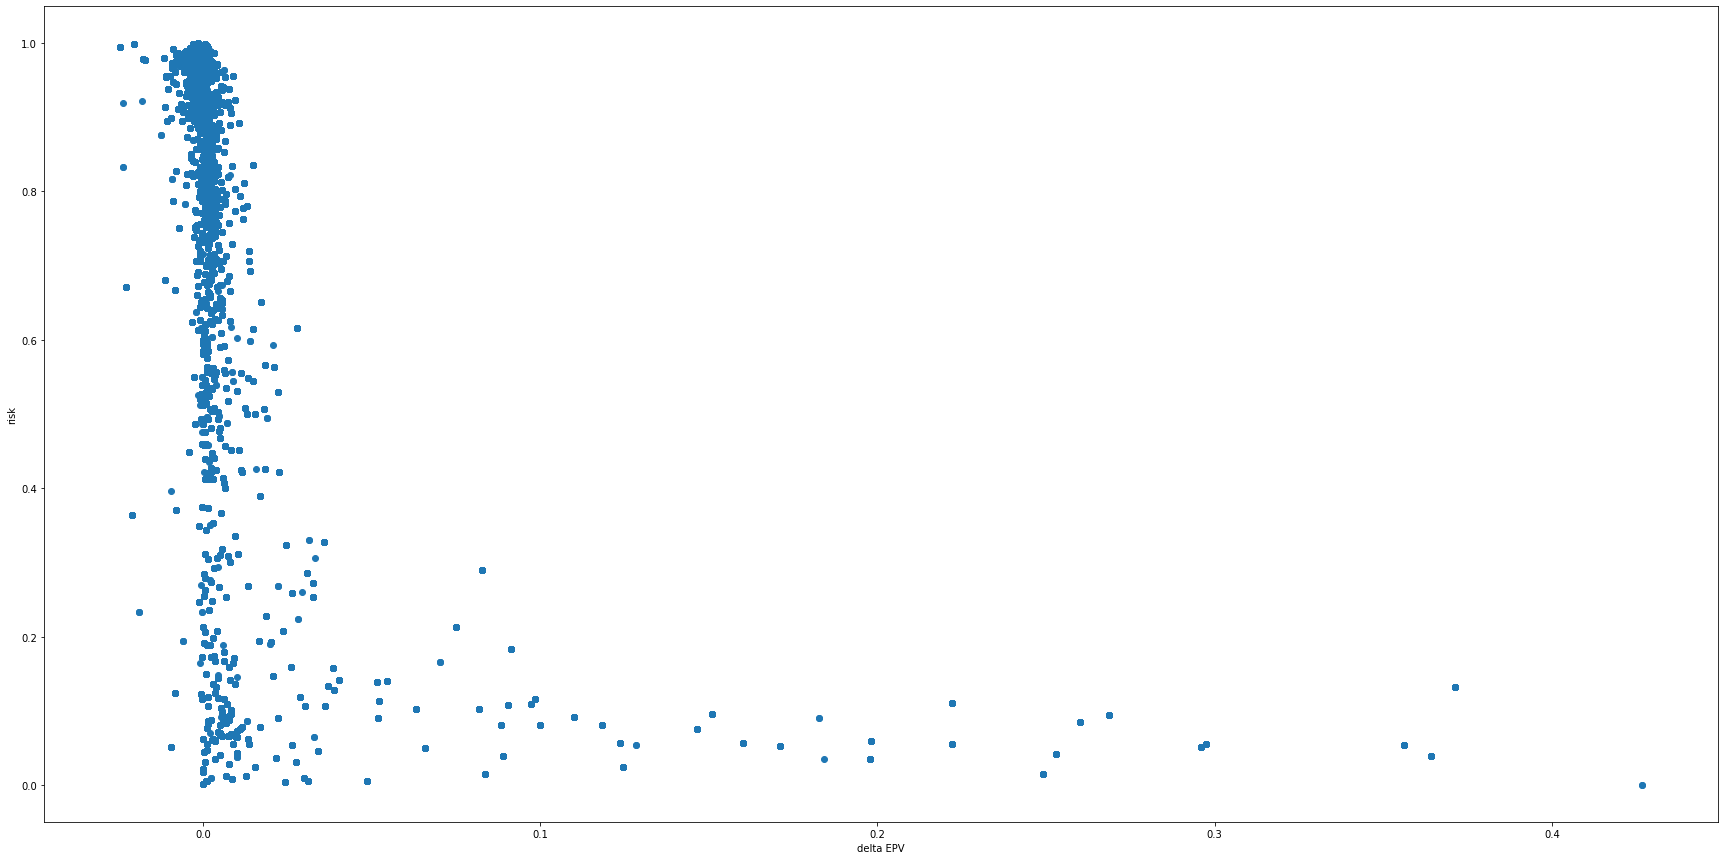

In [92]:
plt.figure(figsize=(30,15))
plt.scatter(match_passes['delta_EPV'],match_passes['risk'])
plt.xlabel('delta EPV')
plt.ylabel('risk')
plt.show()

### Barca player analysis

In [93]:
barca_passes = match_passes[match_passes['team']=='Barcelona']
barca_passes.head(2)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,related_events,pass,match_id,possession_team_id,player_id,under_pressure,counterpress,off_camera,match_week,home_team,away_team,out,outcome,recipient_id,length,angle,height,body_part,end_location,home,opponent,n_related_events,field_zone_x,field_zone_y,end_field_zone_x,end_field_zone_y,prob,risk,delta_EPV,target
19,9c50f2cc-9d20-4132-990d-14a34b08965d,63,1,00:01:00.161,1,0,Pass,3,Barcelona,Regular Play,Barcelona,Marc-André ter Stegen,Goalkeeper,"[14.1, 40.0]",2.067720,[783e4174-5325-4525-8289-98921ebf6262],"{'recipient': {'id': 43728, 'name': 'Óscar Min...",3773631,217,20055,False,False,False,22,Real Betis,Barcelona,NaN,Completed,43728.0,22.995651,0.871604,Ground Pass,Keeper Arm,"[28.9, 57.6]",False,Real Betis,1.0,5,16,12,23,0.010783,0.989217,0.0003,1
20,29475b7b-cfa6-4a14-b72c-cd3e8ff521f0,66,1,00:01:04.944,1,4,Pass,3,Barcelona,Regular Play,Barcelona,Óscar Mingueza García,Right Back,"[49.7, 72.3]",0.805902,[b240a416-6b71-4fb9-ab6f-0407aa75eaf3],"{'recipient': {'id': 5477, 'name': 'Ousmane De...",3773631,217,43728,False,False,False,22,Real Betis,Barcelona,NaN,Completed,5477.0,5.769749,1.122651,Ground Pass,Left Foot,"[52.2, 77.5]",False,Real Betis,1.0,20,28,21,31,0.119226,0.880774,-0.0004,1


In [106]:
stats_player = barca_passes.groupby('player').agg({'under_pressure':'mean','length':'mean','home':'mean','n_related_events':'mean','prob':'mean','risk':'mean','delta_EPV':'mean','target':['mean','count']})
stats_player = stats_player[stats_player[('target','count')]>300]
stats_player

under_pressure     length  \
                                                           mean       mean   
player                                                                       
Antoine Griezmann                                      0.167769  14.852956   
Clément Lenglet                                        0.073469  19.695199   
Francisco António Machado Mota de Castro Trincão       0.162319  14.005164   
Frenkie de Jong                                        0.129384  16.699396   
Gerard Piqué Bernabéu                                  0.073092  21.260783   
Jordi Alba Ramos                                       0.066833  16.286064   
Lionel Andrés Messi Cuccittini                         0.178766  16.782636   
Marc-André ter Stegen                                  0.091381  29.742415   
Miralem Pjanić                                         0.107143  16.353774   
Moriba Kourouma Kourouma                               0.210682  15.193955   
Ousmane Dembélé                                        0.129282  15.979813   
Pedro González López                                   0.168196  17.221337   
Philippe Coutinho Correia                              0.113772  16.082671   
Ricard Puig Martí                                      0.165563  16.916947   
Ronald Federico Araújo da Silva                        0.079118  21.515926   
Samuel Yves Umtiti                                     0.082405  18.875040   
Sergi Roberto Carnicer                                 0.086266  15.458507   
Sergino Dest                                           0.087748  13.931604   
Sergio Busquets i Burgos                               0.114943  18.128529   
Óscar Mingueza García                                  0.083164  17.428481   

                                                      home n_related_events  \
                                                      mean             mean   
player                                                                        
Antoine Griezmann                                 0.561157         1.281818   
Clément Lenglet                                   0.434467         1.171429   
Francisco António Machado Mota de Castro Trincão  0.713043         1.295652   
Frenkie de Jong                                   0.531177         1.233827   
Gerard Piqué Bernabéu                             0.559036         1.200000   
Jordi Alba Ramos                                  0.523588         1.201573   
Lionel Andrés Messi Cuccittini                    0.531683         1.308854   
Marc-André ter Stegen                             0.499481         1.176532   
Miralem Pjanić                                    0.373512         1.199405   
Moriba Kourouma Kourouma                          0.724036         1.296736   
Ousmane Dembélé                                   0.422099         1.259669   
Pedro González López                              0.516208         1.280734   
Philippe Coutinho Correia                         0.692615         1.201597   
Ricard Puig Martí                                 0.599338         1.238411   
Ronald Federico Araújo da Silva                   0.531777         1.184176   
Samuel Yves Umtiti                                0.652561         1.187082   
Sergi Roberto Carnicer                            0.520999         1.200908   
Sergino Dest                                      0.474338         1.187086   
Sergio Busquets i Burgos                          0.504558         1.217202   
Óscar Mingueza García                             0.535497         1.174442   

                                                      prob      risk  \
                                                      mean      mean   
player                                                                 
Antoine Griezmann                                 0.272631  0.734524   
Clément Lenglet                                   0.220483  0.752956   
Francisco António Machado Mota de Castro Trincão  0.298191  0.727652   
Fren

In [107]:
stats_player.sort_values(('target','mean'))

under_pressure     length  \
                                                           mean       mean   
player                                                                       
Francisco António Machado Mota de Castro Trincão       0.162319  14.005164   
Ricard Puig Martí                                      0.165563  16.916947   
Antoine Griezmann                                      0.167769  14.852956   
Philippe Coutinho Correia                              0.113772  16.082671   
Ousmane Dembélé                                        0.129282  15.979813   
Ronald Federico Araújo da Silva                        0.079118  21.515926   
Sergino Dest                                           0.087748  13.931604   
Sergi Roberto Carnicer                                 0.086266  15.458507   
Frenkie de Jong                                        0.129384  16.699396   
Miralem Pjanić                                         0.107143  16.353774   
Jordi Alba Ramos                                       0.066833  16.286064   
Sergio Busquets i Burgos                               0.114943  18.128529   
Óscar Mingueza García                                  0.083164  17.428481   
Lionel Andrés Messi Cuccittini                         0.178766  16.782636   
Pedro González López                                   0.168196  17.221337   
Clément Lenglet                                        0.073469  19.695199   
Marc-André ter Stegen                                  0.091381  29.742415   
Gerard Piqué Bernabéu                                  0.073092  21.260783   
Samuel Yves Umtiti                                     0.082405  18.875040   
Moriba Kourouma Kourouma                               0.210682  15.193955   

                                                      home n_related_events  \
                                                      mean             mean   
player                                                                        
Francisco António Machado Mota de Castro Trincão  0.713043         1.295652   
Ricard Puig Martí                                 0.599338         1.238411   
Antoine Griezmann                                 0.561157         1.281818   
Philippe Coutinho Correia                         0.692615         1.201597   
Ousmane Dembélé                                   0.422099         1.259669   
Ronald Federico Araújo da Silva                   0.531777         1.184176   
Sergino Dest                                      0.474338         1.187086   
Sergi Roberto Carnicer                            0.520999         1.200908   
Frenkie de Jong                                   0.531177         1.233827   
Miralem Pjanić                                    0.373512         1.199405   
Jordi Alba Ramos                                  0.523588         1.201573   
Sergio Busquets i Burgos                          0.504558         1.217202   
Óscar Mingueza García                             0.535497         1.174442   
Lionel Andrés Messi Cuccittini                    0.531683         1.308854   
Pedro González López                              0.516208         1.280734   
Clément Lenglet                                   0.434467         1.171429   
Marc-André ter Stegen                             0.499481         1.176532   
Gerard Piqué Bernabéu                             0.559036         1.200000   
Samuel Yves Umtiti                                0.652561         1.187082   
Moriba Kourouma Kourouma                          0.724036         1.296736   

                                                      prob      risk  \
                                                      mean      mean   
player                                                                 
Francisco António Machado Mota de Castro Trincão  0.298191  0.727652   
Ricard Puig Martí                                 0.201292  0.720432   
Antoine Griezmann                                 0.272631  0.734524   
Phil

In [108]:
stats_player.sort_values(('delta_EPV','mean'),ascending=False)

under_pressure     length  \
                                                           mean       mean   
player                                                                       
Philippe Coutinho Correia                              0.113772  16.082671   
Samuel Yves Umtiti                                     0.082405  18.875040   
Antoine Griezmann                                      0.167769  14.852956   
Jordi Alba Ramos                                       0.066833  16.286064   
Ricard Puig Martí                                      0.165563  16.916947   
Gerard Piqué Bernabéu                                  0.073092  21.260783   
Ronald Federico Araújo da Silva                        0.079118  21.515926   
Sergi Roberto Carnicer                                 0.086266  15.458507   
Pedro González López                                   0.168196  17.221337   
Ousmane Dembélé                                        0.129282  15.979813   
Óscar Mingueza García                                  0.083164  17.428481   
Sergio Busquets i Burgos                               0.114943  18.128529   
Frenkie de Jong                                        0.129384  16.699396   
Clément Lenglet                                        0.073469  19.695199   
Sergino Dest                                           0.087748  13.931604   
Lionel Andrés Messi Cuccittini                         0.178766  16.782636   
Marc-André ter Stegen                                  0.091381  29.742415   
Moriba Kourouma Kourouma                               0.210682  15.193955   
Miralem Pjanić                                         0.107143  16.353774   
Francisco António Machado Mota de Castro Trincão       0.162319  14.005164   

                                                      home n_related_events  \
                                                      mean             mean   
player                                                                        
Philippe Coutinho Correia                         0.692615         1.201597   
Samuel Yves Umtiti                                0.652561         1.187082   
Antoine Griezmann                                 0.561157         1.281818   
Jordi Alba Ramos                                  0.523588         1.201573   
Ricard Puig Martí                                 0.599338         1.238411   
Gerard Piqué Bernabéu                             0.559036         1.200000   
Ronald Federico Araújo da Silva                   0.531777         1.184176   
Sergi Roberto Carnicer                            0.520999         1.200908   
Pedro González López                              0.516208         1.280734   
Ousmane Dembélé                                   0.422099         1.259669   
Óscar Mingueza García                             0.535497         1.174442   
Sergio Busquets i Burgos                          0.504558         1.217202   
Frenkie de Jong                                   0.531177         1.233827   
Clément Lenglet                                   0.434467         1.171429   
Sergino Dest                                      0.474338         1.187086   
Lionel Andrés Messi Cuccittini                    0.531683         1.308854   
Marc-André ter Stegen                             0.499481         1.176532   
Moriba Kourouma Kourouma                          0.724036         1.296736   
Miralem Pjanić                                    0.373512         1.199405   
Francisco António Machado Mota de Castro Trincão  0.713043         1.295652   

                                                      prob      risk  \
                                                      mean      mean   
player                                                                 
Philippe Coutinho Correia                         0.268344  0.738834   
Samuel Yves Umtiti                                0.193843  0.744203   
Antoine Griezmann                                 0.272631  0.734524   
Jord